In [35]:
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Importing Data

In [36]:
data = pd.read_csv(r'E:\Coursera\Machine Learning\Classification\Logistic Reg\Social Ads\Social_Network_Ads.csv')

In [37]:
df1 = data[(data["EstimatedSalary"]<=60000) & (data["Age"]<=30)] 
df2 = data[(data["EstimatedSalary"]>=100000) & (data["Age"]>=40) &(data["Purchased"] ==1)] 
df  = pd.concat([df1 , df2])
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
5,15728773,Male,27,58000,0
8,15600575,Male,25,33000,0


In [38]:
df["EstimatedSalary"] = (df["EstimatedSalary"]-df["EstimatedSalary"].mean())/df["EstimatedSalary"].std()
df["Age"] = (df["Age"]-df["Age"].mean())/df["Age"].std()
df["Purchased"] = df["Purchased"].replace(0 , -2)
df["Purchased"] = df["Purchased"].replace(1 , -1)
df["Purchased"] = df["Purchased"].replace(-2 , 1)
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,-1.211251,-1.126766,1
2,15668575,Female,-0.687089,-0.612480,1
3,15603246,Female,-0.612208,-0.312480,1
5,15728773,Male,-0.612208,-0.291052,1
8,15600575,Male,-0.761969,-0.826766,1


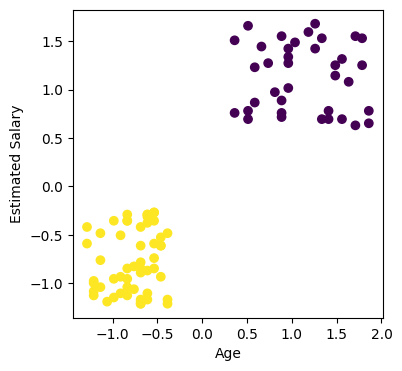

In [39]:
X = df[["Age", "EstimatedSalary"]].to_numpy()
Y = df[["Purchased"]].to_numpy()
plt.figure(figsize=(4, 4))
plt.scatter(X[: , 0],X[: ,1] , c=Y)
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.show()

In [40]:
# Plotting Function For Linear Seperable Data
import pylab as pl

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]
    plt.scatter(X[: , 0] ,X[:  ,1] ,c=Y)
    pl.plot(X1_train[:,0], X1_train[:,1])
    pl.plot(X2_train[:,0], X2_train[:,1])
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")
    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")
    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")
    pl.axis("tight")
    pl.show()

In [41]:
# Plot Function For Linear Non-Seperable
def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.001
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

In [42]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
solvers.options['show_progress'] = False
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, z, degree=2, intercept=0):
    return np.power(np.matmul(x, z.T) + intercept, degree)



class SVM(object):

    def __init__(self, kernel=linear_kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.C = self.C * 1.0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.kernel == polynomial_kernel:
            m, n = X.shape
            K = polynomial_kernel(X, X, degree = 3, intercept = 1)
            P = cvxopt.matrix(np.matmul(y,y.T) * K)
            q = cvxopt.matrix(np.ones((m, 1)) * -1)
            A = cvxopt.matrix(y.reshape(1, -1))
            A = A * 1.0
            b = cvxopt.matrix(np.zeros(1))
            G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
            h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
            solution = solvers.qp(P, q, G, h, A, b)
            # Alphas
            a = np.array(solution['x'])
            print(a)
            self.a=a
            # Weights
            w = np.dot((y * a).T, X)[0]
            self.w =w
            print("w = ",w)
            # B - Intercept
            S = (a > 1e-5).flatten()
            b = np.mean(y[S] - np.dot(X[S], w.reshape(-1,1)))
            self.b=b
            print("b = ",b)
        else:
            # Gram matrix
            K = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(n_samples):
                    K[i,j] = self.kernel(X[i], X[j])

            P = cvxopt.matrix(np.outer(y,y) * K)
            q = cvxopt.matrix(np.ones(n_samples) * -1)
            A = cvxopt.matrix(y, (1,n_samples))
            A = A*1.0
            b = cvxopt.matrix(0.0)
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

            # Quadratic Programming Solution with buitlin cvxopt
            solution = cvxopt.solvers.qp(P, q, G, h, A, b)

            # Our Alphas Values
            a = np.ravel(solution['x'])
            print("alphas: " , a)

            # Support vectors have non zero lagrange multipliers
            sv = a > 1e-5
            ind = np.arange(len(a))[sv]
            self.a = a[sv]
            self.sv = X[sv]
            self.sv_y = y[sv]

            # Intercept
            self.b = 0
            for n in range(len(self.a)):
                self.b += self.sv_y[n]
                self.b = self.b *1.0
                self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
            self.b /= len(self.a)

            # Weight vector
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
            print("W : " ,self.w)
            print("b : " ,self.b)
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

# Linear Seperable Case

In [43]:
# Model Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train , X_test , Y_train , Y_test = train_test_split(X , Y)

clf = SVM(kernel = linear_kernel ,C=1.0)
clf.fit(X_train, Y_train)

alphas:  [1.11578846e-09 1.44906109e-09 3.56420039e-09 1.60048353e-09
 2.42008554e-09 2.07472355e-09 3.25601067e-09 2.79458932e-09
 3.53667936e-08 3.65699456e-09 1.34917418e-09 3.52582097e-09
 2.94508486e-09 3.72298595e-08 2.04561667e-09 2.82412751e-09
 1.65401360e-09 8.07545182e-09 1.47481005e-09 7.86746919e-09
 2.55682684e-09 3.52421047e-09 4.47925849e-09 3.15155240e-09
 2.76400575e-09 1.57394019e-09 6.35584525e-09 5.34515544e-09
 2.17514284e-09 9.99999936e-01 9.28458912e-09 2.46509532e-09
 1.90155893e-09 9.99999968e-01 6.35584525e-09 2.63015440e-09
 1.98801636e-09 1.42992054e-08 2.48067039e-09 7.99230932e-09
 1.54116208e-07 1.44959568e-09 4.55679493e-09 1.63334448e-09
 2.08004761e-09 2.57898489e-09 3.45077103e-08 1.69441557e-08
 3.77349097e-09 8.20402847e-09 2.70651285e-09 6.94364308e-09
 1.91049992e-09 2.13355340e-09 1.43108215e-09 1.91049992e-09
 1.83049763e-09 1.50307488e-09 2.76205842e-09 4.53057264e-09
 1.83117173e-09 3.45077103e-08 1.95083355e-09 1.75061963e-09
 5.08585199e-09

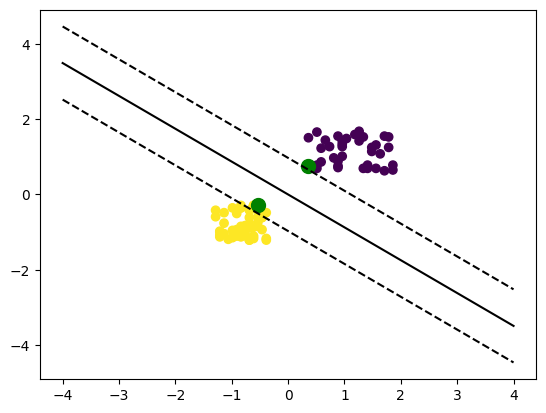

In [44]:
# Plotting Decision Boundaries
plot_margin(X[Y[Y==1]], X[Y[Y==-1]], clf)

In [45]:
# Testing The Model
y_predict = clf.predict(X_test)
print("Accuracy on test set = " , accuracy_score(Y_test , y_predict)*100 ,'%')

Accuracy on test set =  100.0 %


# Linearly Non Seperable

In [46]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
import cvxopt
from cvxopt import solvers


X, y = make_moons(n_samples=150,shuffle=False,  noise=0.25,random_state=10)
y = np.where(y == 0, -1, 1)

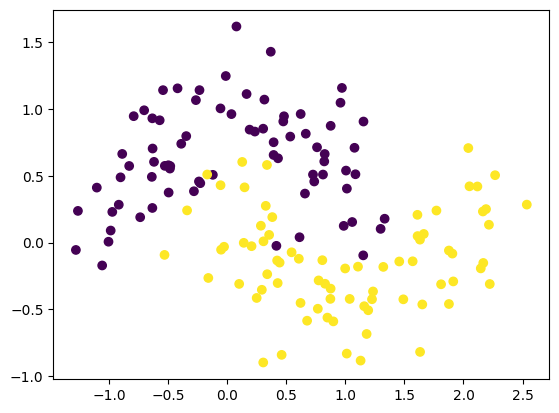

In [47]:
plt.scatter(X[: , 0] ,X[: , 1], c=y)

In [48]:
# Model Training
clf = SVM(kernel = polynomial_kernel ,C=10)
clf.fit(X, y)


[[2.81686452e-11]
 [2.42779310e-10]
 [3.22795956e-11]
 [5.22001256e-11]
 [6.17613859e-11]
 [6.79568458e-11]
 [2.49982601e-10]
 [7.69938095e-11]
 [3.44053858e-10]
 [2.83029804e-11]
 [1.84264102e-03]
 [1.06637947e-10]
 [6.94998364e-11]
 [1.37890734e-10]
 [2.09027791e-10]
 [2.33685591e-10]
 [1.71741529e-10]
 [7.83314301e-11]
 [1.69468940e-10]
 [8.76181780e-11]
 [1.67798217e-10]
 [1.10409815e-09]
 [7.05381072e-10]
 [3.49799674e-10]
 [2.62967519e-10]
 [3.12873711e-10]
 [2.40770528e-10]
 [2.35423697e-10]
 [9.93923838e-11]
 [5.22385220e-10]
 [5.90762708e-10]
 [4.07319893e-10]
 [5.37113383e-10]
 [1.03089980e-09]
 [2.44059415e-10]
 [1.86515573e-10]
 [9.67980057e-11]
 [5.44552351e-11]
 [4.52493561e-11]
 [1.17466054e-10]
 [1.08064759e-10]
 [3.73635972e-11]
 [1.54480290e-08]
 [7.94721368e-11]
 [4.42330395e-09]
 [1.66444070e-10]
 [1.15628850e-10]
 [7.34212805e-11]
 [4.48620569e-11]
 [1.40883267e-03]
 [1.54753535e-10]
 [2.53999940e-11]
 [5.24584247e-11]
 [2.92951963e-11]
 [1.19268954e-10]
 [6.372087

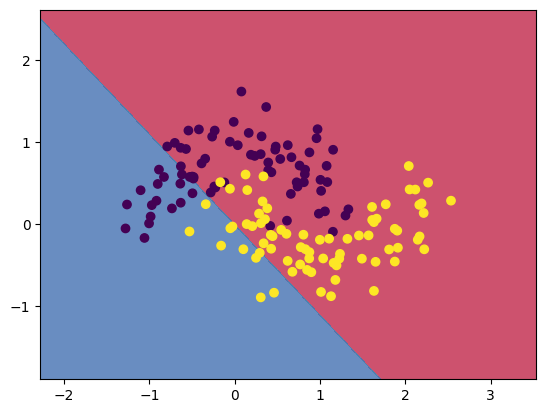

In [49]:
plot_contour(X , y , clf)